# K-Means Clustering

Unsupervised learning is a type of machine learning where the model is trained on data without labeled responses. In this way, the goal of some unsupervised learning algorithms, like K-Means Clustering, is to discover hidden patterns in the data and find the labels.

Unsupervised learning models intend to identify groupings in the data with no predefined labels or outcomes. Particularly, K-Means Clustering is a clustering algorithm used to classify a dataset into *k* distinct, non-overlapping groups or clusters based on similarity.

The algorithm works as follows:



1.   The model is initialized by selecting *k* random points as initial cluster centroids.
2.   Each data point is assigned to a cluster. This is done by calculating the distances between each point and all the centroids and selecting the closest one. There are different ways of calculating the distance, but the most common method is the Euclidean distance.
3. Once every data point is assigned to a cluster, the algorithm proceeds to update the centroids by taking the mean of all the points in that cluster.
4. The algorithm re-starts with the new centroids and defines new clusters until the centroids stabilize or a specific number of iterations is reached.

The key parameters for this model are:

* Number of clusters (k): number of groups to divide the dataset.
* Distance metric: usually Euclidean distance.

$$
\text{distance}(p, q) = \sqrt{\sum (p_i - q_i)^2}
$$

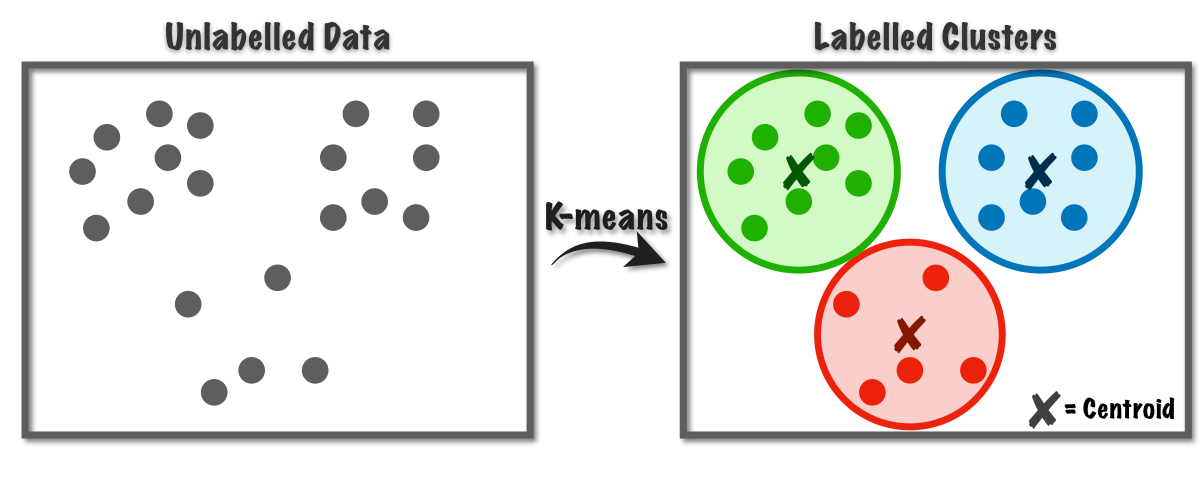


The idea of this project is to use K-Means clustering to find similar counties in the US according to common economic demographics. For this purpose, we will use data from the US census for each county.

**Dataset: US Census Demographic Data from Kaggle**

In [46]:
# We import useful libraries
import pandas as pd
import zipfile
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

In [47]:
!pip install kaggle


In [48]:
!kaggle datasets download -d muonneutrino/us-census-demographic-data

Dataset URL: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data
License(s): CC0-1.0
us-census-demographic-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
!unzip us-census-demographic-data.zip

Archive:  us-census-demographic-data.zip
replace acs2015_census_tract_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [52]:
# We open the dataset with pandas
data = pd.read_csv('acs2017_census_tract_data.csv')

# Display the first few rows of the dataset
data.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [53]:
data.columns.unique()

Index(['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [54]:
# Since we will be working with counties, we aggregate by county, averaging the economic features
aggregated_data = data.groupby('County')[['IncomePerCap', 'Poverty', 'Unemployment']].mean().reset_index()
data_filtered = aggregated_data[['IncomePerCap', 'Poverty', 'Unemployment']].dropna()
print(aggregated_data.head())



             County  IncomePerCap    Poverty  Unemployment
0  Abbeville County  19402.833333  22.183333      9.383333
1     Acadia Parish  21454.250000  21.933333      9.075000
2   Accomack County  24769.750000  20.112500      5.450000
3        Ada County  32672.661017  12.608475      4.633898
4      Adair County  19711.409091  25.909091      5.645455


In [55]:
data = data_filtered

In [56]:
print(data.columns)
print(aggregated_data.columns)


Index(['IncomePerCap', 'Poverty', 'Unemployment'], dtype='object')
Index(['County', 'IncomePerCap', 'Poverty', 'Unemployment'], dtype='object')


**Preliminary Visual Analysis**

First, we will make some map graphs to see poverty, unemployment and GDP per capita by county. For this purpose, we will use geopandas and we will import a geojson map with US counties.

In [57]:
# Geojson map
geojson_url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
counties_geo = gpd.read_file(geojson_url)
counties_geo['County'] = counties_geo['NAME'].str.lower().str.replace(' county', '').str.strip()
aggregated_data['County'] = aggregated_data['County'].str.lower().str.replace(' county', '').str.strip()

# Merge GeoDataFrame with aggregated data
merged = counties_geo.merge(aggregated_data, on='County', how='left')




In [58]:
merged

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,County,IncomePerCap,Poverty,Unemployment
0,01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",autauga,26588.166667,14.558333,5.975000
1,01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.5778 33.76532, -86.75914 33.8406...",blount,25770.486486,14.058333,6.619444
2,01017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87052, -85.12342 32.772...",chambers,24939.500000,17.892857,7.014286
3,01021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",chilton,23577.888889,18.200000,6.822222
4,01033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.5817, -88.13925 34.5878...",colbert,23558.928571,18.100000,6.742857
...,...,...,...,...,...,...,...,...,...,...,...,...
3216,51001,0500000US51001,51,001,Accomack,County,449.496,"MULTIPOLYGON (((-75.24227 38.02721, -75.29687 ...",accomack,24769.750000,20.112500,5.450000
3217,51021,0500000US51021,51,021,Bland,County,357.725,"POLYGON ((-81.2251 37.23487, -81.20477 37.2430...",bland,23685.000000,8.250000,6.750000
3218,51027,0500000US51027,51,027,Buchanan,County,502.763,"POLYGON ((-81.9683 37.5378, -81.92787 37.51212...",buchanan,23825.842105,17.844737,6.065789
3219,51037,0500000US51037,51,037,Charlotte,County,475.271,"POLYGON ((-78.44332 37.0794, -78.49303 36.8912...",charlotte,30472.146341,12.768293,8.500000


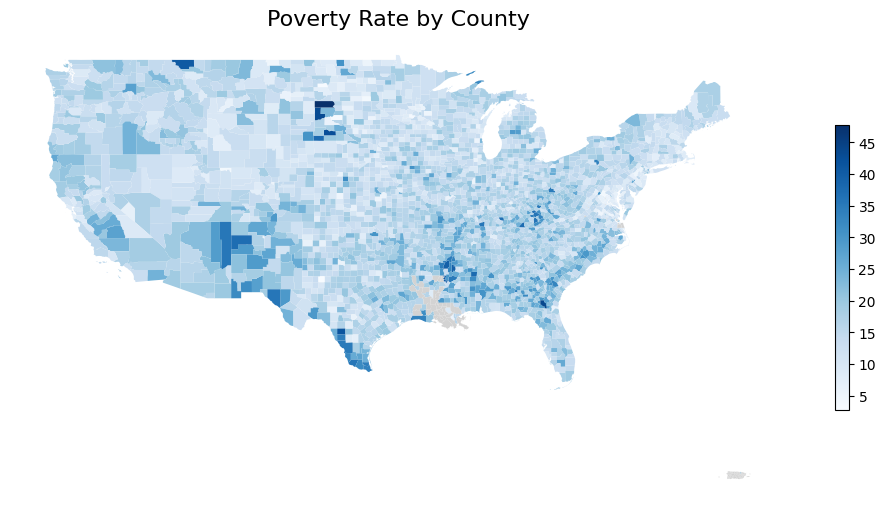

In [59]:
# Filter for the contiguous US (excluding Alaska and Hawaii)
merged = merged[(merged['STATE'] != '02') & (merged['STATE'] != '15')]

def plot_smaller_map(column, cmap, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Adjusted smaller figure size
    merged.plot(
        column=column,
        cmap=cmap,
        legend=True,
        legend_kwds={'shrink': 0.5},  # Shrink legend size to fit better
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Missing data"},
    )
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()  # Remove axes for cleaner visuals
    plt.tight_layout()
    plt.show()

# We plot poverty by county
plot_smaller_map('Poverty', 'Blues', 'Poverty Rate by County')


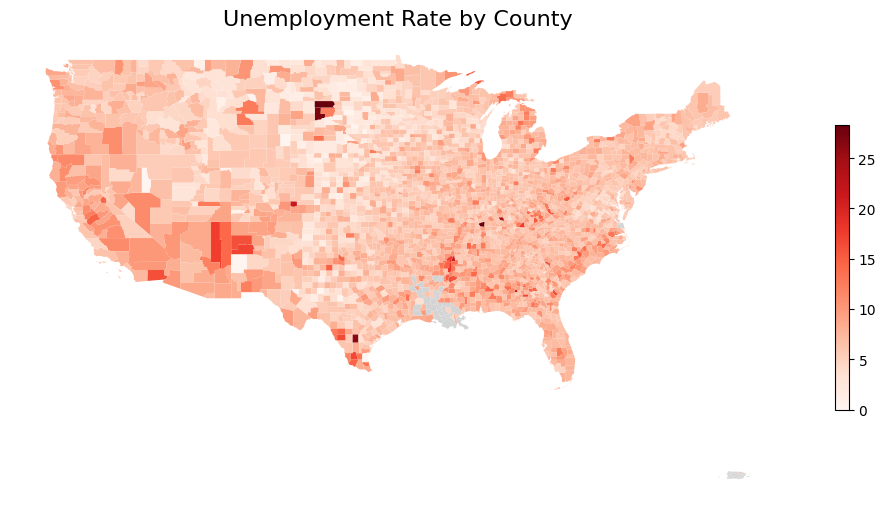

In [60]:
# We plot unemployment by county
plot_smaller_map('Unemployment', 'Reds', 'Unemployment Rate by County')


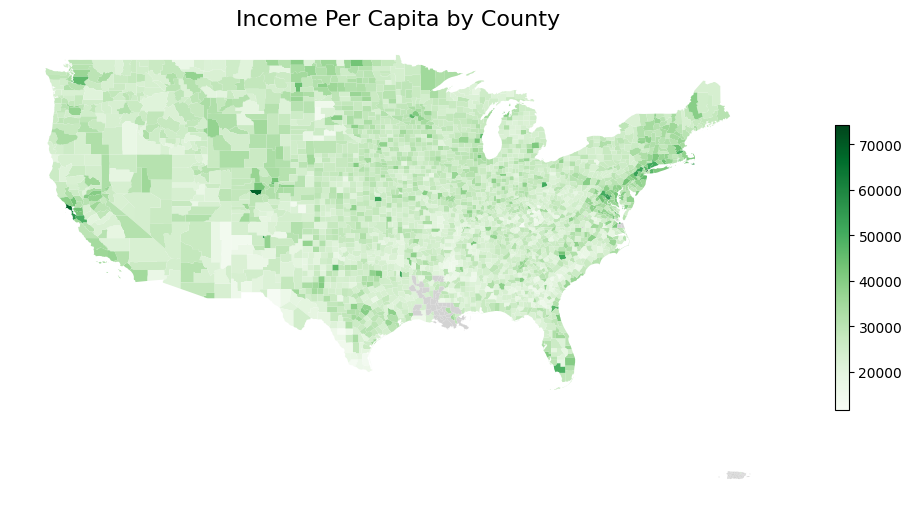

In [61]:
# We plot income per capita by county
plot_smaller_map('IncomePerCap', 'Greens', 'Income Per Capita by County')

Now, we proceed to graph these three variables together through a 3d scatter plot.

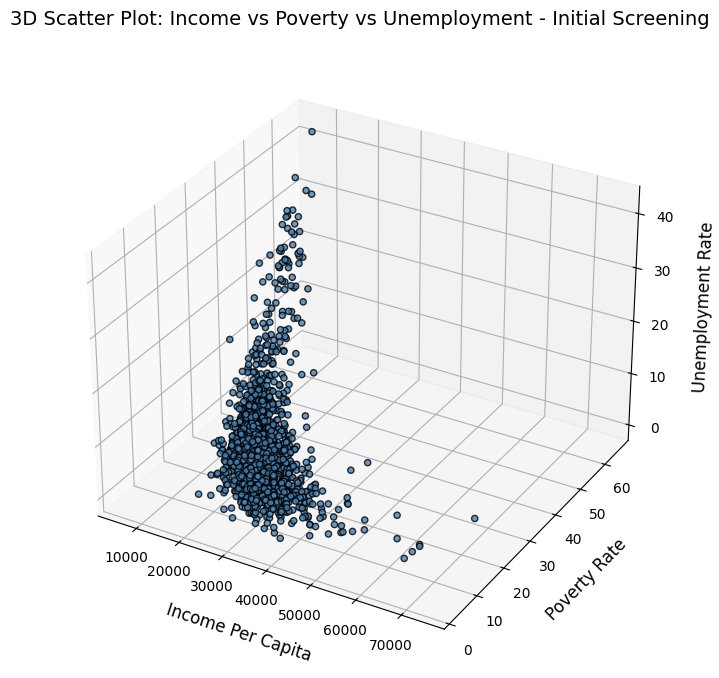

In [62]:
# We generate the 3d scatterplot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d', facecolor='white')

scatter = ax.scatter(
    data['IncomePerCap'],
    data['Poverty'],
    data['Unemployment'],
    c='steelblue',
    alpha=0.8,
    edgecolors='k',
    s=20
)


ax.set_xlabel('Income Per Capita', labelpad=10, fontsize=12, color='black')
ax.set_ylabel('Poverty Rate', labelpad=10, fontsize=12, color='black')
ax.set_zlabel('Unemployment Rate', labelpad=10, fontsize=12, color='black')
ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
ax.set_title('3D Scatter Plot: Income vs Poverty vs Unemployment - Initial Screening', fontsize=14, pad=20, color='black')
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
plt.show()







**K-Means Clustering Model**

Now, we'll proceed to build the model from scratch by:
* defining a function to calculate the distances
* defining a function to assign clusters
* defining a function to calculate new centroids
* defining a function to run the model by consolidating the previous functions

In [63]:

def calculate_distances(data, centroids):
    """
    Calculate the Euclidean distance from each point in the data to each centroid.

    Args:
        data (numpy.ndarray): The dataset, shape (n_samples, n_features).
        centroids (numpy.ndarray): The centroids, shape (k, n_features).

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples, k).
    """
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return distances

In [64]:
def assign_labels(distances):
    """
    Assign each data point to the nearest centroid.

    Args:
        distances (numpy.ndarray): Distance matrix of shape (n_samples, k).

    Returns:
        numpy.ndarray: Array of cluster labels for each data point, shape (n_samples,).
    """
    labels = np.argmin(distances, axis=1)
    return labels


In [65]:
def calculate_new_centroids(data, labels, k):
    """
    Calculate new centroids as the mean of the data points in each cluster.

    Args:
        data (numpy.ndarray): The dataset, shape (n_samples, n_features).
        labels (numpy.ndarray): Cluster labels for each data point, shape (n_samples,).
        k (int): Number of clusters.

    Returns:
        numpy.ndarray: New centroids, shape (k, n_features).
    """
    centroids = np.array([data[labels == cluster].mean(axis=0) for cluster in range(k)])
    return centroids


In [66]:
def kmeans_scratch(data, k, max_iters=100, tol=1e-6):
    """
    K-means clustering algorithm implemented from scratch.

    Args:
        data (numpy.ndarray): The dataset, shape (n_samples, n_features).
        k (int): Number of clusters.
        max_iters (int): Maximum number of iterations.
        tol (float): Tolerance to check for convergence.

    Returns:
        tuple: Cluster labels (n_samples,) and final centroids (k, n_features).
    """
    # Step 1: Initialize centroids randomly
    np.random.seed(42)  # For reproducibility
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for iteration in range(max_iters):
        # Step 2: Calculate distances and assign labels
        distances = calculate_distances(data, centroids)
        labels = assign_labels(distances)

        # Step 3: Calculate new centroids
        new_centroids = calculate_new_centroids(data, labels, k)

        # Check for convergence
        if np.allclose(centroids, new_centroids, atol=tol):
            print(f"Converged after {iteration} iterations.")
            break

        centroids = new_centroids

    return labels, centroids


Now that we have a function for the algorithm, we can run it for our dataset. We'll start by choosing a k=4 for this.

In [67]:
# Prepare the data (IncomePerCap, Poverty, Unemployment)
data_filtered = data[['IncomePerCap', 'Poverty', 'Unemployment']].dropna().to_numpy()

# Run k-means with k=4 clusters
k = 4
labels, centroids = kmeans_scratch(data_filtered, k)

# View results
print("Cluster Centers:\n", centroids)


Converged after 23 iterations.
Cluster Centers:
 [[4.15430708e+04 9.27872508e+00 4.90211704e+00]
 [2.94582303e+04 1.30366540e+01 5.40009292e+00]
 [1.30214376e+04 4.01832435e+01 1.56815581e+01]
 [2.25527298e+04 1.90956357e+01 7.50318202e+00]]


Let's see how the model defined the clusters through a 3d scatter plot

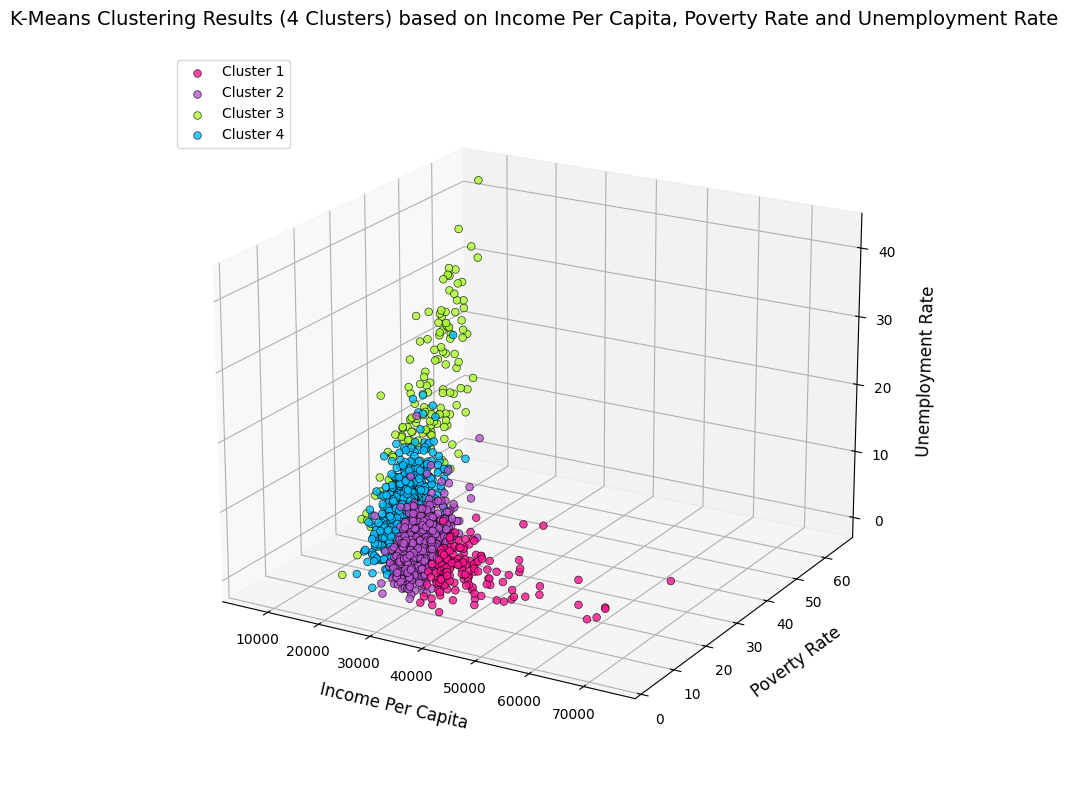

In [68]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d', facecolor='white')
cluster_colors = ['deeppink', 'mediumorchid', 'greenyellow', 'deepskyblue']
cluster_labels = [f'Cluster {i + 1}' for i in range(4)]  # Updated for 4 clusters

for cluster in range(4):  # Updated for 4 clusters
    cluster_points = data_filtered[labels == cluster]
    ax.scatter(
        cluster_points[:, 0],  # IncomePerCap
        cluster_points[:, 1],  # Poverty
        cluster_points[:, 2],  # Unemployment
        c=cluster_colors[cluster],
        label=cluster_labels[cluster],
        alpha=0.8,
        s=30,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_xlabel('Income Per Capita', labelpad=10, fontsize=12)
ax.set_ylabel('Poverty Rate', labelpad=10, fontsize=12)
ax.set_zlabel('Unemployment Rate', labelpad=10, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(loc='upper left', fontsize=10)
ax.set_title('K-Means Clustering Results (4 Clusters) based on Income Per Capita, Poverty Rate and Unemployment Rate', fontsize=14, pad=20)
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
ax.view_init(elev=20, azim=-60)
plt.tight_layout()
plt.show()




**Defining *k*, the number of clusters**

The **elbow method** is a technique used to determine the optimal number of clusters in K-Mean Clustering. It works by plotting the inertia (sum of squared distances between data points and their assigned clsuter centroids) for different values of k.

The idea behind this methodology is that initially, as k increases, the inertia dicreases significantly because more clusters allow points to be closer to their centroids. However, after a certain point, also known as the 'elbow', the decrease in inertia becomes marginal. At this point, adding more clusters provides diminishing returns since the model strats to overfit the data.

This method balances compact clusters and simplicity.

In [69]:
# We define a function to calculate the inertia
def calculate_inertia(data, k_values, max_iters=100, tol=1e-6):
    inertia = []
    for k in k_values:
        np.random.seed(42)
        centroids = data[np.random.choice(data.shape[0], k, replace=False)]
        for iteration in range(max_iters):
            distances = calculate_distances(data, centroids)
            labels = assign_labels(distances)
            new_centroids = calculate_new_centroids(data, labels, k)
            if np.allclose(centroids, new_centroids, atol=tol):
                break
            centroids = new_centroids
        inertia.append(np.sum(np.min(distances, axis=1) ** 2))
    return inertia

# Define k values to test
k_values = range(1, 10)

# Calculate inertia for each k
inertia = calculate_inertia(data_filtered, k_values)

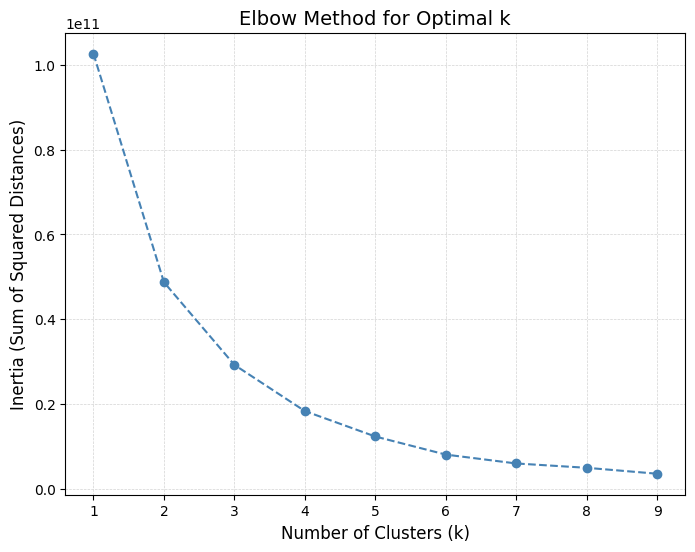

In [70]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--', color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_values)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

As we can see in the plot, the elbow point is at k=3. Therefore, this is the optimal number of clusters for the model.

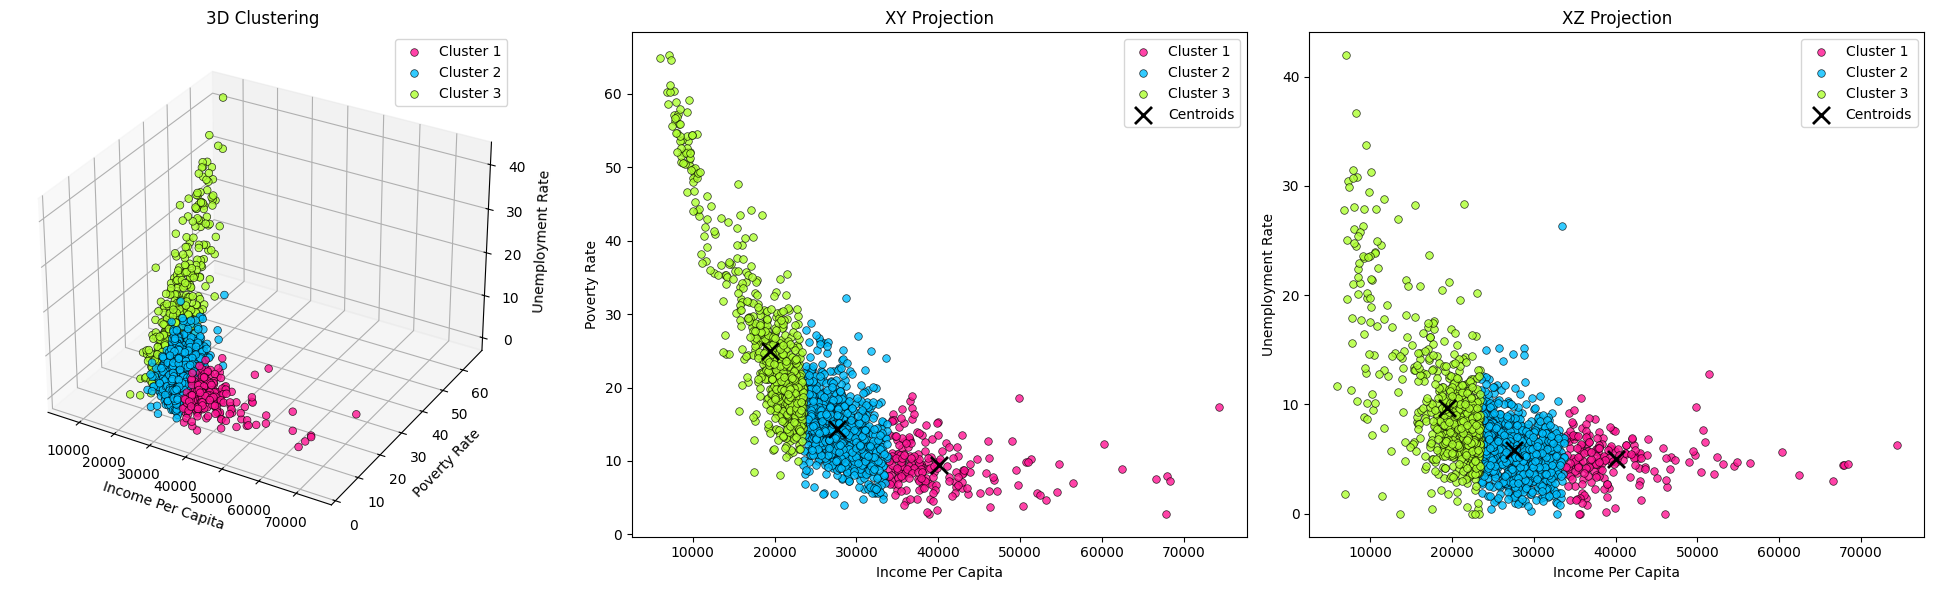

In [71]:
# Run k-means with k=3 clusters
k = 3
np.random.seed(42)
centroids = data_filtered[np.random.choice(data_filtered.shape[0], k, replace=False)]

for _ in range(100):  # Maximum iterations
    distances = calculate_distances(data_filtered, centroids)
    labels = assign_labels(distances)
    new_centroids = calculate_new_centroids(data_filtered, labels, k)
    if np.allclose(centroids, new_centroids, atol=1e-6):
        break
    centroids = new_centroids

# We plot the clusters
cluster_colors = ['deeppink', 'deepskyblue', 'greenyellow']
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131, projection='3d', facecolor='white')
for cluster in range(k):
    cluster_points = data_filtered[labels == cluster]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                c=cluster_colors[cluster], alpha=0.8, s=30, edgecolor='black', linewidth=0.5, label=f'Cluster {cluster + 1}')
ax1.set_xlabel('Income Per Capita')
ax1.set_ylabel('Poverty Rate')
ax1.set_zlabel('Unemployment Rate')
ax1.set_title('3D Clustering')
ax1.legend()

# XY Projection
ax2 = fig.add_subplot(132)
for cluster in range(k):
    cluster_points = data_filtered[labels == cluster]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], c=cluster_colors[cluster], alpha=0.8, s=30,
                edgecolor='black', linewidth=0.5, label=f'Cluster {cluster + 1}')
ax2.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=150, label='Centroids', linewidth=2)
ax2.set_xlabel('Income Per Capita')
ax2.set_ylabel('Poverty Rate')
ax2.set_title('XY Projection')
ax2.legend()

# XZ Projection
ax3 = fig.add_subplot(133)
for cluster in range(k):
    cluster_points = data_filtered[labels == cluster]
    ax3.scatter(cluster_points[:, 0], cluster_points[:, 2], c=cluster_colors[cluster], alpha=0.8, s=30,
                edgecolor='black', linewidth=0.5, label=f'Cluster {cluster + 1}')
ax3.scatter(centroids[:, 0], centroids[:, 2], c='black', marker='x', s=150, label='Centroids', linewidth=2)
ax3.set_xlabel('Income Per Capita')
ax3.set_ylabel('Unemployment Rate')
ax3.set_title('XZ Projection')
ax3.legend()
plt.tight_layout()
plt.show()



Now that we have identified the clusters, let's see how the map with the different counties looks like. We will see which counties belong to each cluster.

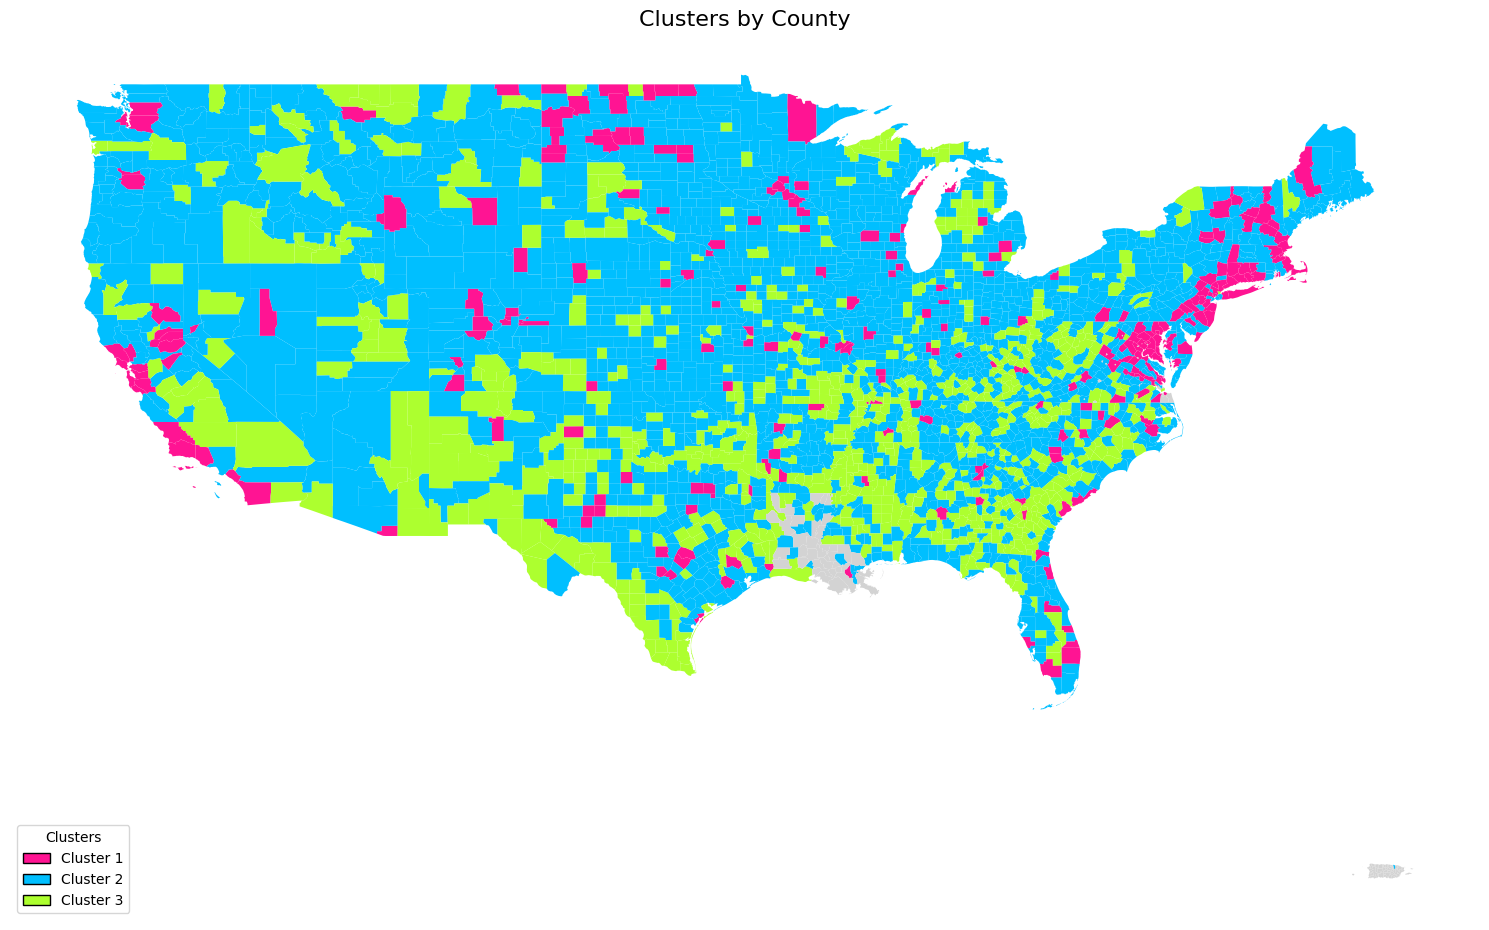

In [72]:

labels_df = pd.DataFrame(labels, columns=['Cluster'])
aggregated_data['Cluster'] = labels_df['Cluster']

counties_geo['County'] = counties_geo['NAME'].str.lower().str.replace(' county', '').str.strip()
aggregated_data['County'] = aggregated_data['County'].str.lower().str.strip()
merged = counties_geo.merge(aggregated_data, on='County', how='left')
merged = merged[(merged['STATE'] != '02') & (merged['STATE'] != '15')]

# We define cluster colors and labels
cluster_colors = ['deeppink', 'deepskyblue', 'greenyellow']
cluster_labels = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
cmap = ListedColormap(cluster_colors)

def plot_cluster_map():
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(
        column='Cluster',
        cmap=cmap,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Missing data"},
    )

    legend_elements = [Patch(facecolor=cluster_colors[i], edgecolor='black', label=cluster_labels[i]) for i in range(len(cluster_colors))]
    ax.legend(handles=legend_elements, loc='lower left', title='Clusters')
    ax.set_title('Clusters by County', fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_cluster_map()


Thanks to K-Means Clustering, we were able to identify three clusters for US counties according to three economic features (poverty rate, unemployment rate and income per capita). We can see that there are three clear groups:

* Cluster 1: shows the best economic results
* Cluster 2: shows medium results.
* Cluster 3: shows more low-income counties.